# Blue Sky Run Engine

Contents:

* The Run Engine processes messages
* There is two-way communication between the message generator and the Run Engine
* Control timing with 'sleep' and 'wait'
* Runs can be aborted
* Any functions can subscribe to the live data stream (e.g., live plotting)

In [36]:
%run bs.py

motor = Mover('motor', ['pos'])
det = SynGauss('sg', motor, 'pos', center=0, Imax=1, sigma=1)

## The Run Engine processes messages

A message has four parts: a command string, an object, a tuple of positional arguments, and a dictionary of keyword arguments.

In [2]:
Msg('set', motor, {'pos': 5})

set: (mover: motor), ({'pos': 5},), {}

In [3]:
Msg('trigger', motor)

trigger: (mover: motor), (), {}

In [4]:
Msg('read', motor)

read: (mover: motor), (), {}

In [37]:
RE = RunEngine()

In [6]:
def simple_scan(motor):
    "Set, trigger, read"
    yield Msg('set', motor, {'pos': 5})
    yield Msg('trigger', motor)
    yield Msg('read', motor)
    
RE.run(simple_scan(motor))

*** Emitted RunStart:
{'scan_id': 123, 'uid': 'b6cbd093-ad92-4e11-b46f-13bd3747efc7', 'owner': 'tester', 'time': 1433033643.5872743, 'beamline_id': 'test'}
MSG_CACHE None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
read: (mover: motor), (), {}
   ret: {'pos': {'timestamp': 1433033643.7077208, 'value': 5}}
MSG_CACHE None
*** Emitted RunStop:
{'run_start': 'b6cbd093-ad92-4e11-b46f-13bd3747efc7', 'reason': '', 'exit_status': 'success', 'time': 1433033643.7281158}


Moving a motor and reading it back is boring. Let's add a detector.

In [7]:
def simple_scan2(motor, det):
    "Set, trigger motor, trigger detector, read"
    yield Msg('set', motor, {'pos': 5})
    yield Msg('trigger', motor)
    yield Msg('trigger', det)
    yield Msg('read', det)
    
RE.run(simple_scan2(motor, det))

*** Emitted RunStart:
{'scan_id': 123, 'uid': '6d21dcb2-5255-4cc4-aeb3-cb7dce40a2a9', 'owner': 'tester', 'time': 1433033644.6109335, 'beamline_id': 'test'}
MSG_CACHE None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433033644.74177, 'value': 3.7266531720786709e-06}}
MSG_CACHE None
*** Emitted RunStop:
{'run_start': '6d21dcb2-5255-4cc4-aeb3-cb7dce40a2a9', 'reason': '', 'exit_status': 'success', 'time': 1433033644.7620864}


## There is two-way communication between the message generator and the Run Engine

Above we the three messages with the responses they generated from the RunEngine. We can use these responses to make our scan adaptive.

In [8]:
def adaptive_scan(motor, det, threshold):
    """Set, trigger, read until the detector reads intensity < threshold"""
    i = 0
    while True:
        print("LOOP %d" % i)
        yield Msg('set', motor, {'pos': i})
        yield Msg('trigger', motor)
        yield Msg('trigger', det)
        reading = yield Msg('read', det)
        if reading['intensity']['value'] < threshold:
            print('DONE')
            break
        i += 1

RE.run(adaptive_scan(motor, det, 0.2))

*** Emitted RunStart:
{'scan_id': 123, 'uid': 'b4701c5d-f58f-4552-89aa-b417db93f5f4', 'owner': 'tester', 'time': 1433033646.3707716, 'beamline_id': 'test'}
MSG_CACHE None
LOOP 0
set: (mover: motor), ({'pos': 0},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433033646.5014837, 'value': 1.0}}
MSG_CACHE None
LOOP 1
set: (mover: motor), ({'pos': 1},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433033646.642324, 'value': 0.60653065971263342}}
MSG_CACHE None
LOOP 2
set: (mover: motor), ({'pos': 2},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (reade

## Control timing with 'sleep' and 'wait'

The 'sleep' command is as simple as it sounds.

In [9]:
def sleepy_scan(motor, det):
    "Set, trigger motor, sleep for a fixed time, trigger detector, read"
    yield Msg('set', motor, {'pos': 5})
    yield Msg('trigger', motor)
    yield Msg('sleep', None, 2)  # units: seconds
    yield Msg('trigger', det)
    yield Msg('read', det)
    
RE.run(sleepy_scan(motor, det))

*** Emitted RunStart:
{'scan_id': 123, 'uid': '67c73980-3a57-4b94-a334-0bc76a5579c4', 'owner': 'tester', 'time': 1433033649.2168798, 'beamline_id': 'test'}
MSG_CACHE None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
sleep: (None), (2,), {}
   ret: None
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433033651.3601696, 'value': 3.7266531720786709e-06}}
MSG_CACHE None
*** Emitted RunStop:
{'run_start': '67c73980-3a57-4b94-a334-0bc76a5579c4', 'reason': '', 'exit_status': 'success', 'time': 1433033651.380584}


The 'wait' command is more powerful. It watches for Movers (e.g., `motor`) to report being done.

### Wait for one motor to be done moving

In [10]:
def wait_one(motor, det):
    "Set, trigger, read"
    yield Msg('set', motor, {'pos': 5})
    yield Msg('trigger', motor, block_group='A')  # Add motor to group 'A'.
    yield Msg('wait', None, 'A')  # Wait for everything in group 'A' to report done.
    yield Msg('trigger', det)
    yield Msg('read', det)
    
RE.run(wait_one(motor, det))

*** Emitted RunStart:
{'scan_id': 123, 'uid': '73aad01b-8419-4047-a4b9-2f0c37fed254', 'owner': 'tester', 'time': 1433033666.912652, 'beamline_id': 'test'}
MSG_CACHE None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {'block_group': 'A'}
   ret: None
MSG_CACHE None
wait: (None), ('A',), {}
   ret: {mover: motor}
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433033667.0535343, 'value': 3.7266531720786709e-06}}
MSG_CACHE None
*** Emitted RunStop:
{'run_start': '73aad01b-8419-4047-a4b9-2f0c37fed254', 'reason': '', 'exit_status': 'success', 'time': 1433033667.0738468}


Notice, in the log, that the response to `wait` is the set of Movers the scan was waiting on.

### Wait for two motors to both be done moving

In [11]:
def wait_multiple(motors, det):
    "Set motors, trigger all motors, wait for all motors to move."
    for motor in motors:
        yield Msg('set', motor, {'pos': 5})
        yield Msg('trigger', motor, block_group='A')  # Trigger each motor and add it to group 'A'.
    yield Msg('wait', None, 'A')  # Wait for everything in group 'A' to report done.
    yield Msg('trigger', det)
    yield Msg('read', det)

motor1 = Mover('motor1', ['pos'])
motor2 = Mover('motor2', ['pos'])

RE.run(wait_multiple([motor1, motor2], det))

*** Emitted RunStart:
{'scan_id': 123, 'uid': '89bace97-1c5d-4602-992b-2809639e4dd4', 'owner': 'tester', 'time': 1433033681.1529896, 'beamline_id': 'test'}
MSG_CACHE None
set: (mover: motor1), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor1), (), {'block_group': 'A'}
   ret: None
MSG_CACHE None
set: (mover: motor2), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor2), (), {'block_group': 'A'}
   ret: None
MSG_CACHE None
wait: (None), ('A',), {}
   ret: {mover: motor1, mover: motor2}
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433033681.4145956, 'value': 3.7266531720786709e-06}}
MSG_CACHE None
*** Emitted RunStop:
{'run_start': '89bace97-1c5d-4602-992b-2809639e4dd4', 'reason': '', 'exit_status': 'success', 'time': 1433033681.4350245}


### Advanced Example: Wait for different groups of motors at different points in the run

If the `'A'` bit seems pointless, the payoff is here. We trigger all the motors at once, wait for the first two, read, wait for the last one, and read again. This is merely meant to show that complex control flow is possible.

In [12]:
def wait_complex(motors, det):
    "Set motors, trigger motors, wait for all motors to move."
    # Same as above...
    for motor in motors[:-1]:
        yield Msg('set', motor, {'pos': 5})
        yield Msg('trigger', motor, block_group='A')
        
    # ...but put the last motor is separate group.
    yield Msg('set', motors[-1], {'pos': 5})
    yield Msg('trigger', motors[-1], block_group='B')
    
    yield Msg('wait', None, 'A')  # Wait for everything in group 'A' to report done.
    yield Msg('trigger', det)
    yield Msg('read', det)
    
    yield Msg('wait', None, 'B')  # Wait for everything in group 'B' to report done.
    yield Msg('trigger', det)
    yield Msg('read', det)
    
motor3 = Mover('motor3', ['pos'])

RE.run(wait_complex([motor1, motor2, motor3], det))

*** Emitted RunStart:
{'scan_id': 123, 'uid': '104a5e39-c587-43fe-8600-f8c50c235b24', 'owner': 'tester', 'time': 1433033683.1643589, 'beamline_id': 'test'}
MSG_CACHE None
set: (mover: motor1), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor1), (), {'block_group': 'A'}
   ret: None
MSG_CACHE None
set: (mover: motor2), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor2), (), {'block_group': 'A'}
   ret: None
MSG_CACHE None
set: (mover: motor3), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor3), (), {'block_group': 'B'}
   ret: None
MSG_CACHE None
wait: (None), ('A',), {}
   ret: {mover: motor1, mover: motor2}
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433033683.546665, 'value': 3.7266531720786709e-06}}
MSG_CACHE None
wait: (None), ('B',), {}
   ret: {mover: motor3}
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE Non

## Runs can be aborted

### SIGINT (Ctrl+C) is reliably caught before each message is processed, even across threads.

The output below is truncated because it caught Ctrl+C (or, in the notebook, "Interrupt Kerenel").

In [13]:
RE.run(sleepy_scan(motor, det))

*** Emitted RunStart:
{'scan_id': 123, 'uid': 'a3b4a867-d692-4f32-8bd3-77e32c04732e', 'owner': 'tester', 'time': 1433033687.170506, 'beamline_id': 'test'}
MSG_CACHE None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
sleep: (None), (2,), {}
   ret: None
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433033689.313401, 'value': 3.7266531720786709e-06}}
MSG_CACHE None
*** Emitted RunStop:
{'run_start': 'a3b4a867-d692-4f32-8bd3-77e32c04732e', 'reason': '', 'exit_status': 'success', 'time': 1433033689.3337846}


In [14]:
def sleepy_scan_checkpoints(motor, det):
    "Set, trigger motor, sleep for a fixed time, trigger detector, read"
    yield Msg('checkpoint')
    yield Msg('set', motor, {'pos': 5})
    yield Msg('trigger', motor)
    yield Msg('sleep', None, 2)  # units: seconds
    yield Msg('trigger', det)
    yield Msg('read', det)

RE.run(sleepy_scan_checkpoints(motor, det))

*** Emitted RunStart:
{'scan_id': 123, 'uid': 'b8edcf78-7495-4f69-beed-eb659cedec58', 'owner': 'tester', 'time': 1433033689.693087, 'beamline_id': 'test'}
MSG_CACHE None
checkpoint: (None), (), {}
   ret: None
MSG_CACHE deque([])
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE deque([set: (mover: motor), ({'pos': 5},), {}])
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE deque([set: (mover: motor), ({'pos': 5},), {}, trigger: (mover: motor), (), {}])
sleep: (None), (2,), {}
   ret: None
MSG_CACHE deque([set: (mover: motor), ({'pos': 5},), {}, trigger: (mover: motor), (), {}, sleep: (None), (2,), {}])
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE deque([set: (mover: motor), ({'pos': 5},), {}, trigger: (mover: motor), (), {}, sleep: (None), (2,), {}, trigger: (reader: sg), (), {}])
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433033691.8467836, 'value': 3.7266531720786709e-06}}
MSG_CACHE deque([set: (mover: motor), ({'pos': 5},), {}, trigger

In [15]:
RE.resume()

### Threading is optional -- switch it off for easier debugging

Again, we'll interrupt the scan. We get exactly the same result, but this time we see a full Traceback.

In [16]:
RE.run(simple_scan(motor), use_threading=False)

*** Emitted RunStart:
{'scan_id': 123, 'uid': 'f602ebc1-6237-4170-b94b-1f8b7d9c87c5', 'owner': 'tester', 'time': 1433033696.9692152, 'beamline_id': 'test'}
MSG_CACHE None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
read: (mover: motor), (), {}
   ret: {'pos': {'timestamp': 1433033697.089708, 'value': 5}}
MSG_CACHE None
*** Emitted RunStop:
{'run_start': 'f602ebc1-6237-4170-b94b-1f8b7d9c87c5', 'reason': '', 'exit_status': 'success', 'time': 1433033697.110275}


## Any functions can subscribe to the live data stream (e.g., live plotting)

In the examples above, the runs have been emitting RunStart and RunStop Documents, but no Events or Event Descriptors. We will add those now.

### Emitting Events and Event Descriptors

The `'create'` and `'save'` commands collect all the reads between them into one Event.

If that particular set of objects has never been bundled into an Event during this run, then an Event Descriptor is also created.

All four Documents -- RunStart, RunStop, Event, and EventDescriptor -- are simply Python dictionaries.

In [21]:
def simple_scan_saving(motor, det):
    "Set, trigger, read"
    yield Msg('create')
    yield Msg('set', motor, {'pos': 5})
    yield Msg('trigger', motor)
    yield Msg('read', motor)
    yield Msg('read', det)
    yield Msg('save')
    
RE.run(simple_scan_saving(motor, det))

*** Emitted RunStart:
{'scan_id': 123, 'uid': 'de269a0a-3130-4e5d-a681-4ed1460271c2', 'owner': 'tester', 'time': 1433033761.0548065, 'beamline_id': 'test'}
MSG_CACHE None
create: (None), (), {}
   ret: None
MSG_CACHE None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
read: (mover: motor), (), {}
   ret: {'pos': {'timestamp': 1433033761.1855886, 'value': 5}}
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433033691.8467836, 'value': 3.7266531720786709e-06}}
MSG_CACHE None
*** Emitted Event Descriptor:
{'uid': '13f52a5f-c8c9-4893-89c5-80b9f202d54e', 'run_start': 'de269a0a-3130-4e5d-a681-4ed1460271c2', 'data_keys': {'I': {'source': 'sg', 'dtype': 'number'}, 'pos': {'source': 'motor', 'dtype': 'number'}}, 'time': 1433033761.2165883}
*** Emitted Event:
{'seq_num': 1, 'descriptor': '13f52a5f-c8c9-4893-89c5-80b9f202d54e', 'uid': 'c85043d2-1859-4408-baa7-812c0867496c', 'data': {'pos'

### Very Simple Example

Any user function that accepts a Python dictionary can be registered as a "consumer" of these Event Documents. Here's a toy example.

In [22]:
def print_event_time(doc):
    print('===== EVENT TIME:', doc['time'], '=====')

To use this consumer function during a run:

In [23]:
RE.run(simple_scan_saving(motor, det), subscriptions={'event': print_event_time})

*** Emitted RunStart:
{'scan_id': 123, 'uid': '6fb9c87e-6f82-4bfb-a5e1-2c349af16475', 'owner': 'tester', 'time': 1433033766.725838, 'beamline_id': 'test'}
MSG_CACHE None
create: (None), (), {}
   ret: None
MSG_CACHE None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
read: (mover: motor), (), {}
   ret: {'pos': {'timestamp': 1433033766.8567212, 'value': 5}}
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433033691.8467836, 'value': 3.726653172078671e-06}}
MSG_CACHE None
*** Emitted Event Descriptor:
{'uid': '1189b4f7-ccb0-41b6-85ef-9a8ba1132352', 'run_start': '6fb9c87e-6f82-4bfb-a5e1-2c349af16475', 'data_keys': {'I': {'source': 'sg', 'dtype': 'number'}, 'pos': {'source': 'motor', 'dtype': 'number'}}, 'time': 1433033766.8877163}
*** Emitted Event:
{'seq_num': 1, 'descriptor': '1189b4f7-ccb0-41b6-85ef-9a8ba1132352', 'uid': '73eafb9b-7d11-46e7-b314-c72607d40887', 'data': {'pos': 

The use it by default on every run for this instance of the Run Engine:

In [24]:
token = RE.subscribe('event', print_event_time)
token

1

The output `token`, an integer, can be use to unsubscribe later.

In [25]:
RE.unsubscribe(token)

### Live Plotting

First, we'll create some axes. The code below updates the plot while the run is ongoing.

<IPython.core.display.Javascript object>


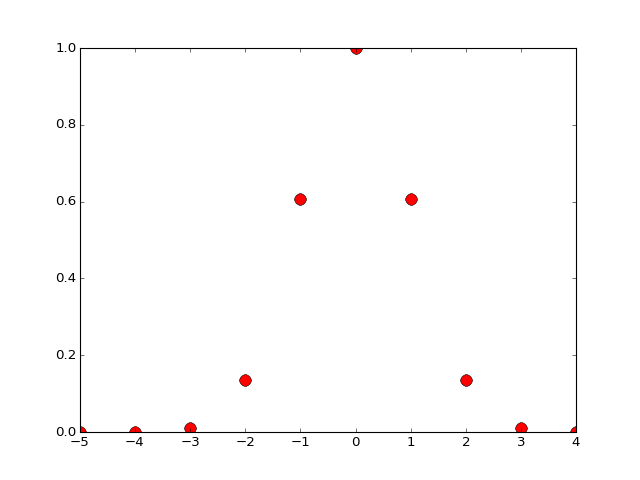

In [26]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

In [27]:
def stepscan(motor, detector):
    for i in range(-5, 5):
        yield Msg('create')
        yield Msg('set', motor, {'pos': i})
        yield Msg('trigger', motor)
        yield Msg('trigger', det)
        yield Msg('read', motor)
        yield Msg('read', detector)
        yield Msg('save')

def live_scalar_plotter(ax, y, x):
    x_data, y_data = [], []
    line, = ax.plot([], [], 'ro', markersize=10)
    def update_plot(doc):
        # Update with the latest data.
        x_data.append(doc['data'][x]['value'])
        y_data.append(doc['data'][y]['value'])
        line.set_data(x_data, y_data)
        # Rescale and redraw.
        ax.relim(visible_only=True)
        ax.autoscale_view(tight=True)
        ax.figure.canvas.draw()
    return update_plot

# Point the function to our axes above, and specify what to plot.
my_plotter = live_scalar_plotter(ax, 'intensity', 'pos')

RE.run(stepscan(motor, det), subscriptions={'event': my_plotter})

*** Emitted RunStart:
{'scan_id': 123, 'uid': '8a9ab1c5-d3d1-4709-87bf-e425f42ff7d4', 'owner': 'tester', 'time': 1433033781.7263868, 'beamline_id': 'test'}
MSG_CACHE None
create: (None), (), {}
   ret: None
MSG_CACHE None
set: (mover: motor), ({'pos': -5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (mover: motor), (), {}
   ret: {'pos': {'timestamp': 1433033781.8568764, 'value': -5}}
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433033781.8672273, 'value': 3.7266531720786709e-06}}
MSG_CACHE None
*** Emitted Event Descriptor:
{'uid': 'ef7d2459-66e4-4f10-a543-297a98ccf8b4', 'run_start': '8a9ab1c5-d3d1-4709-87bf-e425f42ff7d4', 'data_keys': {'I': {'source': 'sg', 'dtype': 'number'}, 'pos': {'source': 'motor', 'dtype': 'number'}}, 'time': 1433033781.8977842}
*** Emitted Event:
{'seq_num': 1, 'descriptor': 'ef7d2459-66e4-4f10-a543-297a98ccf8b4', '

### Saving Documents to metadatastore

Mission-critical consumers can be run on the scan thread, where they will block the scan until they return from processing the emitted Documents. This should not be used for computationally heavy tasks like visualization. Its only intended use is for saving data to metadatastore, but users can register any consumers they want, at risk of slowing down the scan.

```
RE._register_scan_callback('event', some_critical_func)
```

The convenience function `register_mds` registers metadatastore's four `insert_*` functions to consume their four respective Documents. These are registered on the scan thread, so data is guaranteed to be saved in metadatastore.

In [40]:
%run register_mds.py

register_mds(RE)

We can verify that this worked by loading this one-point scan from the DataBroker and displaying the data using DataMuxer.

In [30]:
RE.run(simple_scan_saving(motor, det))

*** Emitted RunStart:
{'scan_id': 123, 'uid': '1227797e-33ee-4fbf-bbf4-fa1a4a29c824', 'owner': 'tester', 'time': 1433033796.3478534, 'beamline_id': 'test'}
MSG_CACHE None
create: (None), (), {}
   ret: None
MSG_CACHE None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
read: (mover: motor), (), {}
   ret: {'pos': {'timestamp': 1433033796.4883633, 'value': 5}}
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433033783.5868258, 'value': 0.00033546262790251185}}
MSG_CACHE None
*** Emitted Event Descriptor:
{'uid': 'ea964ba1-d7e3-4f5e-a377-429b8a1370e3', 'run_start': '1227797e-33ee-4fbf-bbf4-fa1a4a29c824', 'data_keys': {'I': {'source': 'sg', 'dtype': 'number'}, 'pos': {'source': 'motor', 'dtype': 'number'}}, 'time': 1433033796.5189967}
*** Emitted Event:
{'seq_num': 1, 'descriptor': 'ea964ba1-d7e3-4f5e-a377-429b8a1370e3', 'uid': '251243da-d77e-47bc-a9c8-e0e081455571', 'data': {'pos'

In [43]:
from dataportal import DataBroker as db

header = db[-1]
header

<Header scan_id=123 run_start_uid='243d6032-d3dc-47b0-a3b2-b7d46123d8b3'>

In [44]:
from dataportal import DataMuxer as dm

dm.from_events(db.fetch_events(header)).to_sparse_dataframe()

,sin,theta,time
0,0.000000e+00,0.000000,1.433035e+09
1,4.338837e-01,0.448799,1.433035e+09
2,7.818315e-01,0.897598,1.433035e+09
3,9.749279e-01,1.346397,1.433035e+09
4,9.749279e-01,1.795196,1.433035e+09
5,7.818315e-01,2.243995,1.433035e+09
6,4.338837e-01,2.692794,1.433035e+09
7,1.224647e-16,3.141593,1.433035e+09
8,-4.338837e-01,3.590392,1.433035e+09
9,-7.818315e-01,4.039191,1.433035e+09


### Flyscan prototype

   Asserts that flyscans are managed by an object which has three methods:
    
     - describe : same as for everything else
     - kickoff : method which starts the flyscan.  This should be a fast to
         	     execute function that is assumed to just poke at some external
                 hardware.
     - collect : collects the data from flyscan.  This method yields partial
                 event documents.  The 'time' and 'data' fields should be
                 filled in, the rest will be filled in by the run engine.


In [34]:
flyer = FlyMagic('flyer', 'theta', 'sin')

In [41]:
RE.run(fly_gen(flyer))

*** Emitted RunStart:
{'scan_id': 123, 'uid': '243d6032-d3dc-47b0-a3b2-b7d46123d8b3', 'owner': 'tester', 'time': 1433034674.9696984, 'beamline_id': 'test'}
MSG_CACHE None
kickoff: (flyer: flyer), (), {}
   ret: None
MSG_CACHE None
Emitted Event Descriptor:
{'uid': 'a9b77a4f-fe6d-4ba4-a3be-5d915ca58412', 'run_start': '243d6032-d3dc-47b0-a3b2-b7d46123d8b3', 'data_keys': {'sin': {'source': 'flyer', 'dtype': 'number'}, 'theta': {'source': 'flyer', 'dtype': 'number'}}, 'time': 1433034674.9916263}
Emitted Event:
{'uid': '8760ed77-236d-4f49-a996-2252aea79377', 'descriptor': 'a9b77a4f-fe6d-4ba4-a3be-5d915ca58412', 'seq_num': 1, 'data': {'sin': {'timestamp': 1433034674.9814005, 'value': 0.0}, 'theta': {'timestamp': 1433034674.9814005, 'value': 0.0}}, 'time': 1433034674.9814005}
Emitted Event:
{'uid': 'e6f687a9-bfd0-4dfe-b4ba-2595579b1f74', 'descriptor': 'a9b77a4f-fe6d-4ba4-a3be-5d915ca58412', 'seq_num': 2, 'data': {'sin': {'timestamp': 1433034674.9821794, 'value': 0.4338837391175581}, 'theta': 

In [47]:
header = db[-1]
header

<Header scan_id=123 run_start_uid='243d6032-d3dc-47b0-a3b2-b7d46123d8b3'>

In [48]:
res = dm.from_events(db.fetch_events(header)).to_sparse_dataframe()
res

,sin,theta,time
0,0.000000e+00,0.000000,1.433035e+09
1,4.338837e-01,0.448799,1.433035e+09
2,7.818315e-01,0.897598,1.433035e+09
3,9.749279e-01,1.346397,1.433035e+09
4,9.749279e-01,1.795196,1.433035e+09
5,7.818315e-01,2.243995,1.433035e+09
6,4.338837e-01,2.692794,1.433035e+09
7,1.224647e-16,3.141593,1.433035e+09
8,-4.338837e-01,3.590392,1.433035e+09
9,-7.818315e-01,4.039191,1.433035e+09


<IPython.core.display.Javascript object>


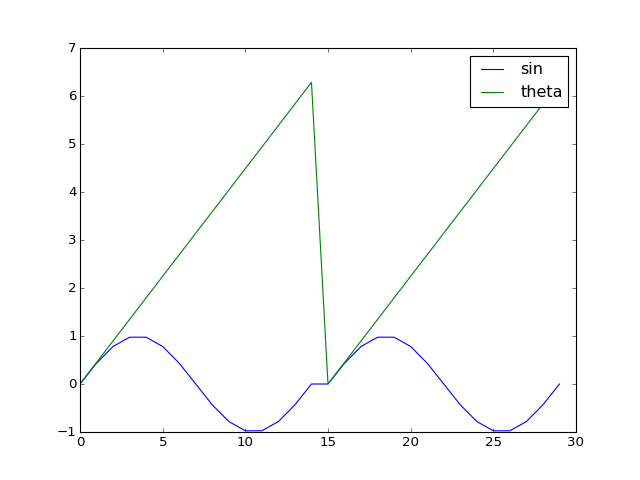

In [51]:
fig, ax = plt.subplots()

In [55]:
ax.cla()
res = dm.from_events(db.fetch_events(header)).to_sparse_dataframe()
ax.plot(res['sin'], label='sin')
ax.plot(res['theta'], label='theta')
ax.legend()
fig.canvas.draw()

### Fly scan + stepscan

Do a step scan with one motor and a fly scan with another

In [56]:
def fly_step_gen(flyer, motor):
    for x in range(-5, 5):   
        yield Msg('create')
        yield Msg('set', motor, {'pos': x})
        yield Msg('trigger', motor)
        yield Msg('read', motor)
        yield Msg('save')
        yield Msg('kickoff', flyer)
        yield Msg('collect', flyer)

In [57]:
RE.run(fly_step_gen(flyer, motor))

*** Emitted RunStart:
{'scan_id': 123, 'uid': '09dcc38b-c0f7-49f7-823a-d5b6ccbed475', 'owner': 'tester', 'time': 1433035911.2858684, 'beamline_id': 'test'}
MSG_CACHE None
create: (None), (), {}
   ret: None
MSG_CACHE None
set: (mover: motor), ({'pos': -5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
read: (mover: motor), (), {}
   ret: {'pos': {'timestamp': 1433035911.4653232, 'value': -5}}
MSG_CACHE None
*** Emitted Event Descriptor:
{'uid': '166594c0-7e1e-4d88-bdca-0ccce31e754f', 'run_start': '09dcc38b-c0f7-49f7-823a-d5b6ccbed475', 'data_keys': {'pos': {'source': 'motor', 'dtype': 'number'}}, 'time': 1433035911.4860528}
*** Emitted Event:
{'seq_num': 1, 'descriptor': '166594c0-7e1e-4d88-bdca-0ccce31e754f', 'uid': 'a18217bb-d281-4764-b0d8-ea4613c15ec0', 'data': {'pos': {'timestamp': 1433035911.4653232, 'value': -5}}, 'time': 1433035911.4875512}
save: (None), (), {}
   ret: None
MSG_CACHE None
kickoff: (flyer: flyer), (), {}
   ret: None

In [58]:
header = db[-1]
header

<Header scan_id=123 run_start_uid='09dcc38b-c0f7-49f7-823a-d5b6ccbed475'>

In [59]:
res = dm.from_events(db.fetch_events(header)).to_sparse_dataframe()
res

,pos,sin,theta,time
0,-5,NaN,NaN,1.433036e+09
1,NaN,0.000000e+00,0.000000,1.433036e+09
2,NaN,4.338837e-01,0.448799,1.433036e+09
3,NaN,7.818315e-01,0.897598,1.433036e+09
4,NaN,9.749279e-01,1.346397,1.433036e+09
5,NaN,9.749279e-01,1.795196,1.433036e+09
6,NaN,7.818315e-01,2.243995,1.433036e+09
7,NaN,4.338837e-01,2.692794,1.433036e+09
8,NaN,1.224647e-16,3.141593,1.433036e+09
9,NaN,-4.338837e-01,3.590392,1.433036e+09
